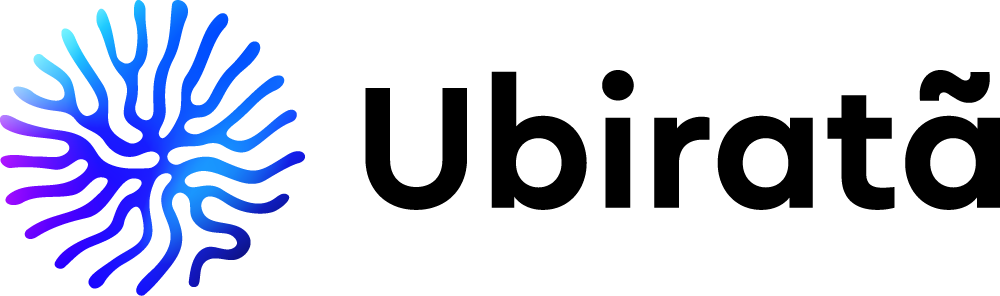

[Paleta de cores logo Ubiratã](https://coolors.co/ffffff-1738fe-57dcff-b7dcfe-9713ff-167bfc-1a9bfd)

**Estudo**

[Plot level sugarcane yield estimation by machine learning on multispectral images: A case study of Bundaberg, Australia](https://www.sciencedirect.com/science/article/pii/S2214317323000574?ref=pdf_download&fr=RR-2&rr=83818622f8c81aa1)

[Predicting the sugarcane yield in real-time by harvester engine parameters and machine learning approaches](https://www.sciencedirect.com/science/article/abs/pii/S0168169920331501?fr=RR-2&ref=pdf_download&rr=838833806d19a486)

# Bibliotecas

In [214]:
! pip install xgboost -U --quiet
! pip install scikit-optimize -U --quiet

In [215]:
import  pandas as pd
import  numpy as np
import  plotly.express as px
import  plotly.graph_objects as go
import  xgboost as xgb
import  time
import  plotly.figure_factory as ff

from    google.colab import drive
from    statsmodels.stats.outliers_influence import variance_inflation_factor
from    sklearn.preprocessing import StandardScaler
from    sklearn.model_selection import (train_test_split,
                                        RandomizedSearchCV)
from    sklearn.metrics import (r2_score,
                                mean_squared_error,
                                mean_absolute_error,
                                max_error,
                                mean_absolute_percentage_error)
from    sklearn.ensemble import RandomForestRegressor
from    skopt import BayesSearchCV
from    skopt.space import (Real,
                            Categorical,
                            Integer)
from    plotly.subplots import make_subplots
from    xgboost import plot_importance
from    scipy.stats import pearsonr

In [216]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
seed = 0

# Dataset

* bloco: índice da região de plantação e colheita de cana-de-açúcar
* talhao: índice da sub-região de plantação e colheita de cana-de-açúcar (Um bloco contém diversos talhões)
* area: área do talhão
* safra: ano que a cana-de-açúcar de cada talhão foi colhida
* data_colheita: data em que a cana-de-açúcar foi colhida
* TCH: Toneladas de cana-de-açúcar colhida por hectare
* NDVI_b01: NDVI é o nome dado a um popular índice de vegetação, e o “b01” corresponde ao índice no primeiro mês antes da colheita
* NDVI_bN: NDVI no N-ésimo mês antes da colheita

NDVI é a sigla para Índice de Vegetação da Diferença Normalizada (Normalized Difference Vegetation Index – do inglês).

É um índice usado para medir a saúde e a densidade da vegetação através de imagens de satélite, auxiliando no monitoramento das lavouras, e nas tomadas de decisão relacionadas ao manejo da cultura.

Este índice apresenta variação numérica de -1 a +1, sendo os valores positivos referentes ao vigor vegetativo da cultura, enquanto que os valores negativos indicam presença de água ou ausência de vegetação.

In [218]:
df = pd.read_csv('/content/drive/MyDrive/Teste Ubiratã/dataset_tch.csv',
                 sep=',',
                 encoding='utf-8')

df['data_colheita'] = pd.to_datetime(df['data_colheita'], format='%Y-%m-%d')

df.sort_values(by='data_colheita', inplace=True)

df.reset_index(drop=True, inplace=True)

df

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


# a)
Faça uma rápida análise exploratória desse dataset, por exemplo análises estatísticas das variáveis, gráficos de distribuição, etc.

In [219]:
df['mil_tonelada_cana'] = df['area'] * df['TCH'] / 1000

df.head()

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792


In [220]:
df[(df['bloco']  == 8) &
   (df['talhao']  == 3)]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.71582,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
577,8,3,94.81,2017,2017-05-02,106.463014,0.780675,0.66705,0.765132,0.817932,0.748939,0.677018,0.588151,0.581472,0.428037,0.422786,0.381811,0.361770,10.093758


NDVI depende diretamente do tipo de cultura e espécie da planta (a espécie pode ter variado entre os anos)

Não é recomendado tirar a média ou mediana

In [221]:
df['safra'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [222]:
df.shape

(1906, 19)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bloco              1906 non-null   int64         
 1   talhao             1906 non-null   int64         
 2   area               1906 non-null   float64       
 3   safra              1906 non-null   int64         
 4   data_colheita      1906 non-null   datetime64[ns]
 5   TCH                1632 non-null   float64       
 6   NDVI_b01           1906 non-null   float64       
 7   NDVI_b02           1906 non-null   float64       
 8   NDVI_b03           1906 non-null   float64       
 9   NDVI_b04           1906 non-null   float64       
 10  NDVI_b05           1906 non-null   float64       
 11  NDVI_b06           1906 non-null   float64       
 12  NDVI_b07           1906 non-null   float64       
 13  NDVI_b08           1906 non-null   float64       
 14  NDVI_b09

In [224]:
df[df.isnull().any(axis=1)]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN


In [225]:
# Verifica dados null em safras diferente de 2019
df[(df.isnull().any(axis=1)) &
   (df['safra'] != 2019)].transpose()

""
bloco
talhao
area
safra
data_colheita
TCH
NDVI_b01
NDVI_b02
NDVI_b03
NDVI_b04


## 2014 a 2018

In [226]:
df_2014_2018 = df[df['safra'] != 2019].copy()

df_2014_2018

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,2018,2018-09-25,20.071738,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951,2.363849
1628,395,3,36.02,2018,2018-09-25,21.880668,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077,0.788142
1629,395,2,95.93,2018,2018-09-25,21.568922,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850,2.069107
1630,395,1,99.16,2018,2018-09-25,31.638724,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220,3.137296


### Estatística descritiva

In [227]:
df_2014_2018.drop(columns=['bloco', 'talhao', 'area', 'safra']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TCH,1632.0,75.234768,29.310767,2.202214,55.833929,74.971461,94.822667,149.940000
NDVI_b01,1632.0,0.534673,0.105107,0.298283,0.458951,0.514620,0.607857,0.822115
NDVI_b02,1632.0,0.564495,0.108507,0.287979,0.482802,0.545404,0.646742,0.845474
NDVI_b03,1632.0,0.601389,0.106995,0.297742,0.517665,0.600873,0.690522,0.833968
NDVI_b04,1632.0,0.642186,0.101480,0.304709,0.566234,0.663929,0.719432,0.834416
NDVI_b05,1632.0,0.661202,0.094809,0.308280,0.617135,0.684114,0.727902,0.847569
NDVI_b06,1632.0,0.661775,0.088612,0.325235,0.615927,0.682218,0.724550,0.815664
NDVI_b07,1632.0,0.642998,0.103593,0.284499,0.591899,0.667638,0.719172,0.817458
NDVI_b08,1632.0,0.622131,0.115120,0.221697,0.550753,0.648504,0.711083,0.840642
NDVI_b09,1632.0,0.574515,0.122088,0.161224,0.488638,0.590327,0.672990,0.805076


### Variação do TCH por safra

In [228]:
fig = px.box(df_2014_2018,
             y='TCH',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=0),
                    title='Variação do TCH por safra',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 25,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [229]:
# Menor TCH
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].min()].transpose()

,171
bloco,119
talhao,6
area,115.53
safra,2014
data_colheita,2014-09-09 00:00:00
TCH,2.202214
NDVI_b01,0.460535
NDVI_b02,0.484786
NDVI_b03,0.545309
NDVI_b04,0.620704


In [230]:
# Maior TCH
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].max()].transpose()

,1277
bloco,387
talhao,2
area,81.39
safra,2018
data_colheita,2018-07-12 00:00:00
TCH,149.94
NDVI_b01,0.505337
NDVI_b02,0.539612
NDVI_b03,0.593915
NDVI_b04,0.625662


### Produção total por safra

In [231]:
df_safra_prod_total = pd.DataFrame(df_2014_2018.groupby('safra')[['mil_tonelada_cana']].sum())

df_safra_prod_total.reset_index(drop=False, inplace=True)

df_safra_prod_total['milhao_tonelada_cana_safra'] = df_safra_prod_total['mil_tonelada_cana'] / 1000

df_safra_prod_total.drop(columns=['mil_tonelada_cana'], inplace=True)

df_safra_prod_total

,safra,milhao_tonelada_cana_safra
0,2014,2.267336
1,2015,0.650106
2,2016,0.336795
3,2017,3.137443
4,2018,3.452381


In [232]:
df_safra_prod_total['milhao_tonelada_cana_safra'].describe()

count    5.000000
mean     1.968812
std      1.419354
min      0.336795
25%      0.650106
50%      2.267336
75%      3.137443
max      3.452381
Name: milhao_tonelada_cana_safra, dtype: float64

In [233]:
fig = px.line(df_safra_prod_total, x='safra', y='milhao_tonelada_cana_safra',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safra_prod_total['milhao_tonelada_cana_safra'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Produção total por safra (em milhões de toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top left', textfont_size=14)

### Variação da produção total por safra

In [234]:
fig = px.box(df_2014_2018,
             y='mil_tonelada_cana',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=10),
                    title='Variação da produção total por safra (em mil toneladas)',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 2,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [235]:
# Menor produção total
df_2014_2018[df_2014_2018['mil_tonelada_cana'] == df_2014_2018['mil_tonelada_cana'].min()].transpose()

,126
bloco,41
talhao,1
area,35.04
safra,2014
data_colheita,2014-08-16 00:00:00
TCH,2.429467
NDVI_b01,0.587291
NDVI_b02,0.637276
NDVI_b03,0.684683
NDVI_b04,0.689298


In [236]:
# Maior produção total
df_2014_2018[df_2014_2018['mil_tonelada_cana'] == df_2014_2018['mil_tonelada_cana'].max()].transpose()

,1239
bloco,476
talhao,5
area,127.05
safra,2018
data_colheita,2018-07-07 00:00:00
TCH,136.491803
NDVI_b01,0.457967
NDVI_b02,0.513287
NDVI_b03,0.612976
NDVI_b04,0.658683


### Produção total por bloco e safra

In [237]:
df_2014_2018_agrupado_safra_bloco = pd.DataFrame(df_2014_2018.groupby(['safra', 'bloco'])[['area', 'mil_tonelada_cana']].sum())

df_2014_2018_agrupado_safra_bloco.rename(columns={'area': 'soma_area'}, inplace=True)

df_2014_2018_agrupado_safra_bloco.reset_index(drop=False, inplace=True)

df_2014_2018_agrupado_safra_bloco

,safra,bloco,soma_area,mil_tonelada_cana
0,2014,5,64.51,9.024144
1,2014,8,328.38,24.135336
2,2014,11,97.08,10.787631
3,2014,12,215.81,27.389096
4,2014,13,67.28,5.585723
...,...,...,...,...
589,2018,470,374.43,42.960117
590,2018,474,518.18,53.970273
591,2018,476,283.35,34.385297
592,2018,477,30.84,3.497698


In [238]:
fig = px.bar(df_2014_2018_agrupado_safra_bloco, x='bloco', y='mil_tonelada_cana', animation_frame='safra')

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total por bloco e safra (em mil toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'},
                  sliders=[{'currentvalue': {'prefix': 'Safra: '}}])

In [239]:
for safra in df_2014_2018_agrupado_safra_bloco['safra'].unique():
    df_safra_bloco = df_2014_2018_agrupado_safra_bloco[df_2014_2018_agrupado_safra_bloco['safra'] == safra]

    quantidade_blocos = df_safra_bloco['bloco'].value_counts().sum()

    milhao_tonelada_safra = df_safra_bloco['mil_tonelada_cana'].sum() / 1000

    print(f'Safra: {safra} - Blocos: {quantidade_blocos} - Total produzido: {milhao_tonelada_safra:.2f} milhões toneladas')

Safra: 2014 - Blocos: 154 - Total produzido: 2.27 milhões toneladas
Safra: 2015 - Blocos: 53 - Total produzido: 0.65 milhões toneladas
Safra: 2016 - Blocos: 27 - Total produzido: 0.34 milhões toneladas
Safra: 2017 - Blocos: 188 - Total produzido: 3.14 milhões toneladas
Safra: 2018 - Blocos: 172 - Total produzido: 3.45 milhões toneladas


### Produtividade por bloco e safra

In [240]:
fig = go.Figure()

fig = px.scatter(df_2014_2018_agrupado_safra_bloco,
                 x='soma_area',
                 y='mil_tonelada_cana',
                 color='bloco',
                 animation_frame='safra')

fig.update_layout(height=600,
                  width=1200,
                  showlegend=False,
                  legend={'title_text': 'Bloco',
                          'traceorder': 'normal'},
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=80,
                              r=50,
                              b=50,
                              t=80,
                              pad=1),
                  title='Produtividade por bloco e safra',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 20,
                         'rangemode': 'tozero',
                         'title': 'Mil toneladas'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 100,
                         'title': 'Soma da área do bloco (hectares)',
                         'rangemode': 'tozero'},
                  sliders=[{'currentvalue': {'prefix': 'Safra: '}}])

### Correlações e multicolinearidade

[Correlation in machine learning — All you need to know](https://medium.com/@abdallahashraf90x/all-you-need-to-know-about-correlation-for-machine-learning-e249fec292e9)

#### Features

In [241]:
features = df.drop(['TCH',
                    'safra',
                    'mil_tonelada_cana'], axis=1).columns

features = features.drop('data_colheita')

features

Index(['bloco', 'talhao', 'area', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03',
       'NDVI_b04', 'NDVI_b05', 'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09',
       'NDVI_b10', 'NDVI_b11', 'NDVI_b12'],
      dtype='object')

#### Target

In [242]:
target = ['mil_tonelada_cana']

target

['mil_tonelada_cana']

In [243]:
X_2014_2018 = df_2014_2018[features]

y_2014_2018 = df_2014_2018[target]

In [244]:
X_2014_2018

,bloco,talhao,area,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951
1628,395,3,36.02,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077
1629,395,2,95.93,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850
1630,395,1,99.16,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220


In [245]:
y_2014_2018

,mil_tonelada_cana
0,6.603058
1,7.670066
2,6.765070
3,3.097142
4,9.000792
...,...
1627,2.363849
1628,0.788142
1629,2.069107
1630,3.137296


In [246]:
correlacao = X_2014_2018.corr().round(2)

fig = px.imshow(correlacao, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')

fig.update_layout(margin=dict(t=50,
                              r=50,
                              b=50,
                              l=50),
                  showlegend=False,
                  coloraxis_showscale=False,
                  width=800,
                  height=800)

fig.update_xaxes(side='top')

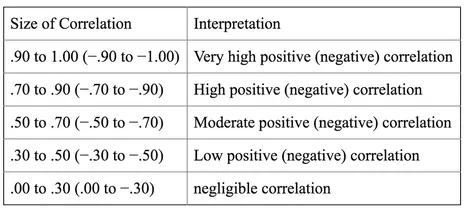

[Fonte: Everything you need to know about interpreting correlations](https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8#:~:text=If%20the%20P%2Dvalue%20is%20bigger%20than%20the%20significance%20level,and%20y%20in%20the%20population%E2%80%9D)

In [247]:
# Seleciona dados acima da diagonal principal
dados_acima_diagonal_principal = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(bool))

# Retorna os nome (index) das colunas com correlção maior que o valor deifnido
nome_dados_acima_diagonal_principal = [column for column in dados_acima_diagonal_principal.columns \
                                       if any(dados_acima_diagonal_principal[column] > 0.6)]

nome_dados_acima_diagonal_principal

['NDVI_b02',
 'NDVI_b03',
 'NDVI_b04',
 'NDVI_b08',
 'NDVI_b09',
 'NDVI_b10',
 'NDVI_b11',
 'NDVI_b12']

In [248]:
dados_acima_diagonal_principal[nome_dados_acima_diagonal_principal]

,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
bloco,-0.16,-0.14,-0.10,0.16,0.14,0.15,0.20,0.14
talhao,0.00,0.03,0.01,-0.09,-0.13,-0.12,-0.15,-0.11
area,-0.04,-0.01,0.01,0.01,-0.00,0.00,-0.01,-0.01
NDVI_b01,0.79,0.72,0.47,-0.38,-0.39,-0.20,-0.03,0.05
NDVI_b02,NaN,0.77,0.66,-0.36,-0.34,-0.30,-0.09,0.03
NDVI_b03,NaN,NaN,0.73,-0.27,-0.31,-0.30,-0.19,-0.03
NDVI_b04,NaN,NaN,NaN,-0.13,-0.19,-0.21,-0.16,-0.06
NDVI_b05,NaN,NaN,NaN,0.23,0.10,0.05,-0.02,-0.01
NDVI_b06,NaN,NaN,NaN,0.41,0.26,0.16,0.02,-0.00
NDVI_b07,NaN,NaN,NaN,0.66,0.56,0.42,0.23,0.11


In [249]:
import itertools

# Cria as combinações de pares de features
combinacao = list(itertools.combinations(nome_dados_acima_diagonal_principal, 2))

significancia = 0.05

# alcula o coeficiente de correlação de Pearson e o p-valor para ca da combinação
for pair in combinacao:
    coef_pearson, p_value = pearsonr(X_2014_2018[pair[0]], X_2014_2018[pair[1]])

    if p_value < significancia:
        print(f'\n{pair}: p_valor {p_value:.4f} < {significancia}')
        print('A correlação É estatisticamente significante')
        print(f'Coeficiente de correlação: {coef_pearson:.2f}')

    # else:
    #     print(f'\n{pair}: p_valor {p_value:.4f} > {significancia}')
    #     print('A correlação NÃO é estatisticamente significante')


('NDVI_b02', 'NDVI_b03'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.77

('NDVI_b02', 'NDVI_b04'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.66

('NDVI_b02', 'NDVI_b08'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.36

('NDVI_b02', 'NDVI_b09'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.34

('NDVI_b02', 'NDVI_b10'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.30

('NDVI_b02', 'NDVI_b11'): p_valor 0.0003 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.09

('NDVI_b03', 'NDVI_b04'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.73

('NDVI_b03', 'NDVI_b08'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de corre

## Fator de inflação da variância

In [250]:
df_vif = pd.DataFrame()

df_vif['feature'] = X_2014_2018.columns

df_vif['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018, i) for i in range(X_2014_2018.shape[1])]


fig = go.Figure(go.Bar(y=df_vif['feature'],
                       x=df_vif['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': True})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=False)

#### Scaler

In [251]:
scaler = StandardScaler()

X_2014_2018_scaled = scaler.fit_transform(X_2014_2018)

In [252]:
df_vif_scaled = pd.DataFrame()

df_vif_scaled['feature'] = X_2014_2018.columns

df_vif_scaled['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018_scaled, i) for i in range(X_2014_2018_scaled.shape[1])]


fig = go.Figure(go.Bar(y=df_vif_scaled['feature'],
                       x=df_vif_scaled['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif_scaled['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância<br>Fatures redimensionadas',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': False})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=True)

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

[Fonte: Documentação StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

## 2019

In [253]:
df_2019 = df[df['safra'] == 2019].copy()

df_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN


In [254]:
for nome_coluna, valores in df_2019.items():
    if 'NDVI_b' in nome_coluna:

        hist_data = [valores]
        group_labels = [str(nome_coluna)]

        media = df_2019[nome_coluna].mean()
        mediana = df_2019[nome_coluna].median()

        fig = ff.create_distplot(hist_data,
                                 group_labels,
                                 show_hist=False,
                                 show_rug=False)

        fig.update_layout(height=400,
                          width=1200,
                          showlegend=False,
                          plot_bgcolor='#F9F9F9',
                          paper_bgcolor='#F9F9F9',
                          margin=dict(l=50,
                                      r=50,
                                      b=50,
                                      t=80,
                                      pad=10),
                          title='Índice de Vegetação da Diferença Normalizada 2019 - ' + str(nome_coluna),
                          yaxis={'showgrid': False},
                          xaxis={'showgrid': False,
                                 'showticklabels': True})

        fig.add_vline(x=media, line_width=2, line_dash='dash',
                      line_color='green', annotation_text='Média',
                      annotation_font_color='green', annotation_position='top left')

        fig.add_vline(x=mediana, line_width=2, line_dash='dash',
                      line_color='red', annotation_text='Mediana',
                      annotation_font_color='red', annotation_position='bottom right')

        fig.show()

# b)

Desenvolva um modelo capaz de prever o TCH dos blocos do dataset para a safra de 2019 (atenção que a previsão deve ser no nível de blocos e não de talhões).

## Train test split

In [255]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_2014_2018,
                                                        y_2014_2018,
                                                        test_size=0.3,
                                                        random_state=seed)

print('\nShape do X_treino: ', X_treino.shape)
print('Shape do y_treino: ', y_treino.shape)

print('\nShape do X_teste: ', X_teste.shape)
print('Shape do y_teste: ', y_teste.shape)


Shape do X_treino:  (1142, 15)
Shape do y_treino:  (1142, 1)

Shape do X_teste:  (490, 15)
Shape do y_teste:  (490, 1)


In [256]:
X_treino_scaled = scaler.fit_transform(X_treino)

X_teste_scaled = scaler.transform(X_teste)

In [257]:
X_2019 = df_2019[features]

y_2019 = df_2019[target]

print('\nShape do X_2019: ', X_2019.shape)
print('Shape do y_2019: ', y_2019.shape)


Shape do X_2019:  (274, 15)
Shape do y_2019:  (274, 1)


In [258]:
X_2019_scaled = scaler.transform(X_2019)

In [259]:
X_2019_scaled

array([[ 1.19765505, -0.72968125,  0.82084762, ..., -0.42080779,
         0.30258042,  0.45063897],
       [ 0.76597079, -0.72968125,  1.67995924, ...,  0.62233758,
         0.84565602,  1.418351  ],
       [ 0.76597079, -0.27949433,  0.15985837, ..., -0.00516134,
         0.33178854,  0.73948103],
       ...,
       [ 1.62202262, -0.72968125,  0.81840597, ...,  0.06527754,
        -0.08490766, -0.61520278],
       [ 0.51720359, -0.72968125,  1.57950283, ...,  1.33891231,
         1.28296882,  1.26348279],
       [ 1.13912159, -0.50458779, -1.56673625, ...,  0.52203402,
         0.31962597,  0.52482482]])

Aplica-se .fit_transform() em X_treino enquanto usamos .transform() em X_test.

Isso é feito para dimensionar o conjunto de teste com os mesmos parâmetros do conjunto de treinamento, mas evitar vazamento de dados.

fit_transform calcula os valores de escala e os aplica, enquanto .transform apenas aplica os valores calculados.

## XGBoost

In [260]:
t1_xgbr_teste = time.perf_counter()


# Modelo XGBoost Regressor
modelo_xgbr = xgb.XGBRegressor()

params_xgbr = {'n_estimators':  [300, 400, 500, 600, 1000],
               'learning_rate': [0.1, 0.01, 0.001],
               'booster':       ['dart', 'gbtree'],  # Tree based models
               'eval_metric':   ['mae'],
               'objective':     ['reg:squarederror']}


# Random search dos melhores parametros
xgbr_rand_search = RandomizedSearchCV(modelo_xgbr,
                                      param_distributions=params_xgbr,
                                      n_iter=5,
                                      cv=5,  # Cross-validation
                                      scoring='neg_mean_squared_error',
                                      error_score='raise',
                                      verbose=3,
                                      random_state=seed)

xgbr_rand_search.fit(X_treino_scaled, y_treino)


# Define o modelo XGBRegressor com melhores parâmetros
melhor_xgbr_regressor = xgbr_rand_search.best_estimator_

evalset = [(X_treino_scaled, y_treino), (X_teste_scaled ,y_teste)]

melhor_xgbr_regressor.fit(X_treino_scaled,
                          y_treino,
                          verbose=False)

pred_xgbr_teste = melhor_xgbr_regressor.predict(X_teste_scaled)

pred_xgbr_teste = pd.Series(pred_xgbr_teste, index=y_teste.index)


t2_xgbr_teste = time.perf_counter()
tempo_total_xgbr_teste = t2_xgbr_teste - t1_xgbr_teste
print(f'Tempo de execução: {tempo_total_xgbr_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_xgbr_teste) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-4.686 total time= 1.2min
[CV 2/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-4.681 total time=  35.4s
[CV 3/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-4.653 total time=  40.3s
[CV 4/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-4.913 total time=  35.4s
[CV 5/5] END booster=dart, eval_metric=mae, learning_rate=0.1, n_estimators=500, objective=reg:squarederror;, score=-4.812 total time=  53.5s
[CV 1/5] END booster=gbtree, eval_metric=mae, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-6.931 total time=   4.2s
[CV 2/5] END booster=gbtree, eval_metric=mae, learning_rate=0.001, n_estimators=600,

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

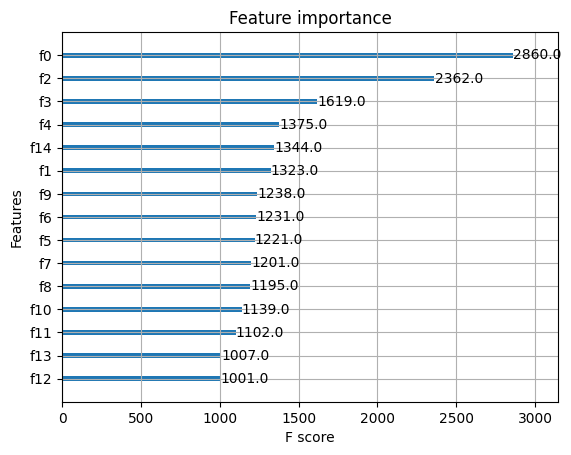

In [261]:
plot_importance(melhor_xgbr_regressor)

In [262]:
xgbr_rand_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'learning_rate': 0.1,
 'eval_metric': 'mae',
 'booster': 'dart'}

In [263]:
pred_xgbr_teste

1336     4.832952
587      7.939467
602      9.836620
527      3.550685
76       7.525618
          ...    
330      2.032326
1010     6.689968
1038     4.223523
1624     3.159938
56      12.938337
Length: 490, dtype: float32

In [264]:
# Métricas de avaliacao
rmse_xgbr_teste = mean_squared_error(y_teste, pred_xgbr_teste.values, squared=False)
rmse_xgbr_teste = round(rmse_xgbr_teste, 2)
print(f'RMSE XGBoost teste: {rmse_xgbr_teste}')

mae_xgbr_teste = mean_absolute_error(y_teste, pred_xgbr_teste.values)
mae_xgbr_teste = round(mae_xgbr_teste, 2)
print(f'MAE XGBoost teste: {mae_xgbr_teste}')

max_error_xgbr_teste = max_error(y_teste, pred_xgbr_teste.values)
max_error_xgbr_teste = round(max_error_xgbr_teste, 2)
print(f'Max error XGBoost teste: {max_error_xgbr_teste}')

mape_xgbr_teste = mean_absolute_percentage_error(y_teste, pred_xgbr_teste.values) * 100
mape_xgbr_teste = round(mape_xgbr_teste, 2)
print(f'MAPE XGBoost teste: {rmse_xgbr_teste}%')

r2_score_xgbr_teste = r2_score(y_teste, pred_xgbr_teste.values) * 100
r2_score_xgbr_teste = round(r2_score_xgbr_teste, 2)
print(f'R2 XGBoost teste: {r2_score_xgbr_teste}%')

RMSE XGBoost teste: 2.22
MAE XGBoost teste: 1.65
Max error XGBoost teste: 7.71
MAPE XGBoost teste: 2.22%
R2 XGBoost teste: 58.52%


In [265]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=y_teste.index, y=y_teste['mil_tonelada_cana'],
                         mode='markers',
                         name='mil_tonelada_cana_teste'))

fig.add_trace(go.Scatter(x=pred_xgbr_teste.index, y=pred_xgbr_teste,
                         mode='markers',
                         name='mil_tonelada_cana_pred'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Correlação entre mil_tonelada_cana_teste e mil_tonelada_cana_teste_pred (XGBRegressor)',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

### Pred TCH 2019

In [266]:
X_2019_scaled

array([[ 1.19765505, -0.72968125,  0.82084762, ..., -0.42080779,
         0.30258042,  0.45063897],
       [ 0.76597079, -0.72968125,  1.67995924, ...,  0.62233758,
         0.84565602,  1.418351  ],
       [ 0.76597079, -0.27949433,  0.15985837, ..., -0.00516134,
         0.33178854,  0.73948103],
       ...,
       [ 1.62202262, -0.72968125,  0.81840597, ...,  0.06527754,
        -0.08490766, -0.61520278],
       [ 0.51720359, -0.72968125,  1.57950283, ...,  1.33891231,
         1.28296882,  1.26348279],
       [ 1.13912159, -0.50458779, -1.56673625, ...,  0.52203402,
         0.31962597,  0.52482482]])

In [267]:
t1 = time.perf_counter()

pred_mil_tonelada_cana_2019_xgbr_regressor = melhor_xgbr_regressor.predict(X_2019_scaled)

pred_mil_tonelada_cana_2019_xgbr_regressor = pd.Series(pred_mil_tonelada_cana_2019_xgbr_regressor, index=y_2019.index)

y_2019['mil_tonelada_cana_xgbr_regressor'] = pred_mil_tonelada_cana_2019_xgbr_regressor

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.05 segundos
Tempo de execução: 0.00 minutos


In [268]:
y_2019

,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor
1632,NaN,9.490778
1633,NaN,12.085504
1634,NaN,6.709376
1635,NaN,4.054470
1636,NaN,4.003053
...,...,...
1901,NaN,4.607007
1902,NaN,3.189862
1903,NaN,7.141897
1904,NaN,12.348930


## Random Forest

In [269]:
t1_rand_forest_teste = time.perf_counter()


# Modelo Random Forest
rand_forest_regressor = RandomForestRegressor(random_state=seed)

param_space = {'bootstrap': [True, False],                  # Statistical resampling technique that involves random sampling of a dataset
               'criterion': ['squared_error'],              # The function to measure the quality of a split
               'max_depth': [2, 4, 8, 16, 32],              # The maximum depth of the tree
               'min_samples_leaf': [2, 3, 4],               # The minimum number of samples required to be at a leaf node
               'min_samples_split': [2, 3, 4, 5],           # The minimum number of samples required to split an internal node
               'n_estimators': [300, 400, 500, 600, 1000]}  # The number of trees in the forest

# Random search dos melhores parametros
rand_forest_search = RandomizedSearchCV(rand_forest_regressor,
                                        param_space,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=5,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=1,
                                        random_state=seed)

rand_forest_search.fit(X_treino_scaled, np.ravel(y_treino))


# Define o modelo Random Forest com melhores parâmetros
melhor_rand_forest_regressor = RandomForestRegressor(**rand_forest_search.best_params_)

melhor_rand_forest_regressor.fit(X_treino_scaled, np.ravel(y_treino))

pred_rand_forest_teste = melhor_rand_forest_regressor.predict(X_teste_scaled)

pred_rand_forest_teste = pd.Series(pred_rand_forest_teste, index=y_teste.index)


t2_rand_forest_teste = time.perf_counter()
tempo_total_rand_forest_teste = t2_rand_forest_teste - t1_rand_forest_teste
print(f'Tempo de execução: {tempo_total_rand_forest_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_rand_forest_teste) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Tempo de execução: 139.32 segundos
Tempo de execução: 2.32 minutos


In [270]:
melhor_rand_forest_regressor.feature_importances_

array([0.03357285, 0.0176573 , 0.47446798, 0.027065  , 0.05818911,
       0.06124818, 0.06775413, 0.04042082, 0.04150755, 0.02756003,
       0.02375364, 0.02187425, 0.02061322, 0.0305786 , 0.05373732])

In [271]:
rand_forest_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 16,
 'criterion': 'squared_error',
 'bootstrap': True}

In [272]:
pred_rand_forest_teste

1336     4.917533
587      7.642722
602     10.165011
527      2.999811
76       7.599524
          ...    
330      2.095317
1010     6.695078
1038     4.472879
1624     3.462652
56      12.902155
Length: 490, dtype: float64

In [273]:
# Métricas de avaliacao
rmse_rand_forest_teste = mean_squared_error(y_teste, pred_rand_forest_teste.values, squared=False)
rmse_rand_forest_teste = round(rmse_rand_forest_teste, 2)
print(f'RMSE Random Forest teste: {rmse_rand_forest_teste}')

mae_rand_forest_teste = mean_absolute_error(y_teste, pred_rand_forest_teste.values)
mae_rand_forest_teste = round(mae_rand_forest_teste, 2)
print(f'MAE Random Forest teste: {mae_rand_forest_teste}')

max_error_rand_forest_teste = max_error(y_teste, pred_rand_forest_teste.values)
max_error_rand_forest_teste = round(max_error_rand_forest_teste, 2)
print(f'Max error Random Forest teste: {max_error_rand_forest_teste}')

mape_rand_forest_teste = mean_absolute_percentage_error(y_teste, pred_rand_forest_teste.values) * 100
mape_rand_forest_teste = round(mape_rand_forest_teste, 2)
print(f'MAPE Random Forest teste: {rmse_rand_forest_teste}%')

r2_score_rand_forest_teste = r2_score(y_teste, pred_rand_forest_teste.values) * 100
r2_score_rand_forest_teste = round(r2_score_rand_forest_teste, 2)
print(f'R2 Random Forest teste: {r2_score_rand_forest_teste}%')

RMSE Random Forest teste: 2.17
MAE Random Forest teste: 1.63
Max error Random Forest teste: 8.39
MAPE Random Forest teste: 2.17%
R2 Random Forest teste: 60.07%


**Random Search**

In random search, you specify a distribution of hyperparameter values, and a set of random combinations of these values are sampled and used to train and evaluate the model.

Random search is often faster than grid search, as it does not evaluate all possible combinations of hyperparameters.

[Fonte: A Comprehensive Guide to Random Forest Regression](https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf)

In [274]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=y_teste.index, y=y_teste['mil_tonelada_cana'],
                         mode='markers',
                         name='mil_tonelada_cana_teste'))

fig.add_trace(go.Scatter(x=pred_rand_forest_teste.index, y=pred_rand_forest_teste,
                         mode='markers',
                         name='mil_tonelada_cana_pred'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Correlação entre mil_tonelada_cana_teste e mil_tonelada_cana_teste_pred (Random Forest)',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

### Pred TCH 2019

In [275]:
t1 = time.perf_counter()

pred_mil_tonelada_cana_2019_rand_forest_regressor = melhor_rand_forest_regressor.predict(X_2019_scaled)

pred_mil_tonelada_cana_2019_rand_forest_regressor = pd.Series(pred_mil_tonelada_cana_2019_rand_forest_regressor, index=y_2019.index)

y_2019['mil_tonelada_cana_rand_forest_regressor'] = pred_mil_tonelada_cana_2019_rand_forest_regressor

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.05 segundos
Tempo de execução: 0.00 minutos


In [276]:
y_2019

,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor
1632,NaN,9.490778,9.224672
1633,NaN,12.085504,13.147652
1634,NaN,6.709376,7.372217
1635,NaN,4.054470,4.398804
1636,NaN,4.003053,3.726612
...,...,...,...
1901,NaN,4.607007,4.713885
1902,NaN,3.189862,3.373283
1903,NaN,7.141897,7.497534
1904,NaN,12.348930,10.821033


## Random Forest Bayes

**Otimização Bayesian**

In Bayesian optimization, a probabilistic model is used to model the unknown function that maps hyperparameters to the model’s performance.

The model is then used to guide the search for the optimal hyperparameters.

[Fonte: A Comprehensive Guide to Random Forest Regression](https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf)

At a high-level, Bayesian optimization methods are efficient because they choose the next hyperparameters in an informed manner.

The basic idea is: spend a little more time selecting the next hyperparameters in order to make fewer calls to the objective function.

[Fonte: A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)

In [277]:
t1_rand_forest_bayes_teste = time.perf_counter()


# Modelo Random Forest
rand_forest_regressor = RandomForestRegressor(random_state=seed)

search_space = {'bootstrap': Categorical([True, False]),
                'max_depth': Integer(6, 20),
                'max_features': Categorical(['sqrt', 'log2']),
                'min_samples_leaf': Integer(2, 10),
                'min_samples_split': Integer(2, 5),
                'n_estimators': Integer(100, 500)}

forest_bayes_search = BayesSearchCV(rand_forest_regressor,
                                    search_space,
                                    scoring='neg_mean_absolute_error',
                                    n_iter=5,
                                    cv=5,
                                    n_jobs=-1,
                                    random_state=seed)

forest_bayes_search.fit(X_treino, np.ravel(y_treino))

melhor_rand_forest_bayes = RandomForestRegressor(**forest_bayes_search.best_params_)

melhor_rand_forest_bayes.fit(X_treino_scaled, np.ravel(y_treino))

pred_rand_forest_bayes_teste = melhor_rand_forest_bayes.predict(X_teste_scaled)

pred_rand_forest_bayes_teste = pd.Series(pred_rand_forest_bayes_teste, index=y_teste.index)


t2_rand_forest_bayes_teste = time.perf_counter()
tempo_total_rand_forest_bayes_teste = t2_rand_forest_bayes_teste - t1_rand_forest_bayes_teste
print(f'Tempo de execução: {tempo_total_rand_forest_bayes_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_rand_forest_bayes_teste) / 60:.2f} minutos')

Tempo de execução: 24.67 segundos
Tempo de execução: 0.41 minutos


In [278]:
melhor_rand_forest_bayes.feature_importances_

array([0.03311419, 0.01404594, 0.46172541, 0.04283534, 0.04842596,
       0.05897143, 0.07380688, 0.04625054, 0.03988757, 0.02509562,
       0.02524983, 0.02253667, 0.0257369 , 0.03314955, 0.04916818])

In [279]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 17),
             ('max_features', 'log2'),
             ('min_samples_leaf', 6),
             ('min_samples_split', 4),
             ('n_estimators', 371)])

In [280]:
pred_rand_forest_bayes_teste

1336     4.495643
587      7.816170
602      9.385347
527      4.442192
76       7.842729
          ...    
330      1.831411
1010     6.533700
1038     4.354675
1624     3.644968
56      10.577873
Length: 490, dtype: float64

In [281]:
# Métricas de avaliacao
rmse_rand_forest_bayes_teste = mean_squared_error(y_teste, pred_rand_forest_bayes_teste.values, squared=False)
rmse_rand_forest_bayes_teste = round(rmse_rand_forest_bayes_teste, 2)
print(f'RMSE Random Forest Bayes teste: {rmse_rand_forest_bayes_teste}')

mae_rand_forest_bayes_teste = mean_absolute_error(y_teste, pred_rand_forest_bayes_teste.values)
mae_rand_forest_bayes_teste = round(mae_rand_forest_bayes_teste, 2)
print(f'MAE Random Forest Bayes teste: {mae_rand_forest_bayes_teste}')

max_error_rand_forest_bayes_teste = max_error(y_teste, pred_rand_forest_bayes_teste.values)
max_error_rand_forest_bayes_teste = round(max_error_rand_forest_bayes_teste, 2)
print(f'Max error Random Forest Bayes teste: {max_error_rand_forest_bayes_teste}')

mape_rand_forest_bayes_teste = mean_absolute_percentage_error(y_teste, pred_rand_forest_bayes_teste.values) * 100
mape_rand_forest_bayes_teste = round(mape_rand_forest_bayes_teste, 2)
print(f'MAPE Random Forest Bayes teste: {rmse_rand_forest_bayes_teste}%')

r2_score_rand_forest_bayes_teste = r2_score(y_teste, pred_rand_forest_bayes_teste.values) * 100
r2_score_rand_forest_bayes_teste = round(r2_score_rand_forest_bayes_teste, 2)
print(f'R2 Random Forest Bayes teste: {r2_score_rand_forest_bayes_teste}%')

RMSE Random Forest Bayes teste: 2.22
MAE Random Forest Bayes teste: 1.67
Max error Random Forest Bayes teste: 8.08
MAPE Random Forest Bayes teste: 2.22%
R2 Random Forest Bayes teste: 58.25%


In [282]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=y_teste.index, y=y_teste['mil_tonelada_cana'],
                         mode='markers',
                         name='mil_tonelada_cana_teste'))

fig.add_trace(go.Scatter(x=pred_rand_forest_bayes_teste.index, y=pred_rand_forest_bayes_teste,
                         mode='markers',
                         name='mil_tonelada_cana_pred'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Correlação entre mil_tonelada_cana_teste e mil_tonelada_cana_teste_pred (Random Forest Bayes)',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

### Pred TCH 2019

In [283]:
t1 = time.perf_counter()

pred_mil_tonelada_cana_2019_rand_forest_bayes = melhor_rand_forest_bayes.predict(X_2019_scaled)

pred_mil_tonelada_cana_2019_rand_forest_bayes = pd.Series(pred_mil_tonelada_cana_2019_rand_forest_bayes, index=y_2019.index)

y_2019['mil_tonelada_cana_rand_forest_bayes'] = pred_mil_tonelada_cana_2019_rand_forest_bayes

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.06 segundos
Tempo de execução: 0.00 minutos


In [284]:
y_2019

,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes
1632,NaN,9.490778,9.224672,9.605225
1633,NaN,12.085504,13.147652,11.104783
1634,NaN,6.709376,7.372217,8.018884
1635,NaN,4.054470,4.398804,4.704851
1636,NaN,4.003053,3.726612,4.573349
...,...,...,...,...
1901,NaN,4.607007,4.713885,4.893298
1902,NaN,3.189862,3.373283,3.986011
1903,NaN,7.141897,7.497534,6.965252
1904,NaN,12.348930,10.821033,9.296483


## Coleta de resultados

In [285]:
mil_tonelada_cana_xgbr_regressor = pd.concat([df_2014_2018['mil_tonelada_cana'], y_2019['mil_tonelada_cana_xgbr_regressor']], axis=0)

mil_tonelada_cana_rand_forest_regressor = pd.concat([df_2014_2018['mil_tonelada_cana'], y_2019['mil_tonelada_cana_rand_forest_regressor']], axis=0)

mil_tonelada_cana_rand_forest_bayes = pd.concat([df_2014_2018['mil_tonelada_cana'], y_2019['mil_tonelada_cana_rand_forest_bayes']], axis=0)

In [286]:
df_2014_2019 = df.copy()

df_2014_2019['mil_tonelada_cana_xgbr_regressor'] = mil_tonelada_cana_xgbr_regressor

df_2014_2019['mil_tonelada_cana_rand_forest_regressor'] = mil_tonelada_cana_rand_forest_regressor

df_2014_2019['mil_tonelada_cana_rand_forest_bayes'] = mil_tonelada_cana_rand_forest_bayes

df_2014_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,...,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058,6.603058,6.603058,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,...,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066,7.670066,7.670066,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,...,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070,6.765070,6.765070,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,...,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142,3.097142,3.097142,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,...,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792,9.000792,9.000792,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN,4.607007,4.713885,4.893298
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN,3.189862,3.373283,3.986011
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN,7.141897,7.497534,6.965252
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN,12.348930,10.821033,9.296483


In [287]:
df_2014_2019_agrupado_bloco = df_2014_2019[df_2014_2019['safra'] == 2019].groupby('bloco').sum()

df_2014_2019_agrupado_bloco.reset_index(drop=False, inplace=True)

df_2014_2019_agrupado_bloco

<ipython-input-287-be2eee3b3380>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,bloco,talhao,area,safra,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,...,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes
0,13,1,67.28,2019,0.0,0.688200,0.718599,0.732889,0.700157,0.702455,...,0.550311,0.444463,0.409690,0.427989,0.486711,0.501093,0.0,6.723969,6.026542,5.873225
1,16,1,31.34,2019,0.0,0.561317,0.611405,0.674954,0.662746,0.665600,...,0.595787,0.593090,0.375706,0.471425,0.384695,0.375208,0.0,2.266341,2.196166,3.561734
2,17,21,432.42,12114,0.0,3.999530,4.166051,4.156167,3.959398,3.891229,...,3.517707,2.739435,2.409677,2.380063,2.830045,2.980745,0.0,39.064563,34.139840,36.390282
3,19,1,94.64,2019,0.0,0.557562,0.622865,0.743437,0.764749,0.750387,...,0.688869,0.626937,0.370526,0.477837,0.326793,0.303321,0.0,9.348070,9.111658,8.497109
4,20,3,128.85,4038,0.0,1.138048,1.223652,1.463459,1.500162,1.481539,...,1.444101,1.322068,0.748208,0.753024,0.726219,0.660565,0.0,12.616264,12.617203,12.788563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,463,21,552.85,12114,0.0,2.479996,3.166682,3.447394,4.088144,4.343657,...,4.093422,3.612785,3.508883,2.524095,2.055733,1.802740,0.0,37.340911,35.803430,36.063145
111,464,6,264.29,6057,0.0,2.031889,2.246860,1.817471,2.187716,1.965861,...,1.503895,1.250442,1.482647,1.725189,1.862911,1.667356,0.0,25.340630,25.528016,24.047358
112,468,12,150.14,6057,0.0,2.230861,2.251037,2.300944,1.710271,2.304834,...,1.909624,1.337930,1.050307,1.252623,1.481919,1.501413,0.0,15.544152,13.301719,16.197113
113,473,3,219.79,4038,0.0,0.897920,1.156609,1.346961,1.518553,1.454349,...,1.432192,1.402224,1.316593,0.976624,0.668293,0.724418,0.0,16.165715,16.788426,16.301552


In [288]:
df_safras_mil_tonelada_cana = pd.DataFrame(df_2014_2019.groupby('safra')[['mil_tonelada_cana_xgbr_regressor',
                                                                          'mil_tonelada_cana_rand_forest_regressor',
                                                                          'mil_tonelada_cana_rand_forest_bayes']].sum())

df_safras_mil_tonelada_cana.reset_index(drop=False, inplace=True)

df_safras_mil_tonelada_cana['milhao_tonelada_cana_xgbr_regressor'] = df_safras_mil_tonelada_cana['mil_tonelada_cana_xgbr_regressor'] / 1000

df_safras_mil_tonelada_cana['milhao_tonelada_cana_rand_forest_regressor'] = df_safras_mil_tonelada_cana['mil_tonelada_cana_rand_forest_regressor'] / 1000

df_safras_mil_tonelada_cana['milhao_tonelada_cana_rand_forest_bayes'] = df_safras_mil_tonelada_cana['mil_tonelada_cana_rand_forest_bayes'] / 1000

df_safras_mil_tonelada_cana

,safra,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes,milhao_tonelada_cana_xgbr_regressor,milhao_tonelada_cana_rand_forest_regressor,milhao_tonelada_cana_rand_forest_bayes
0,2014,2267.336283,2267.336283,2267.336283,2.267336,2.267336,2.267336
1,2015,650.105849,650.105849,650.105849,0.650106,0.650106,0.650106
2,2016,336.794911,336.794911,336.794911,0.336795,0.336795,0.336795
3,2017,3137.442989,3137.442989,3137.442989,3.137443,3.137443,3.137443
4,2018,3452.381182,3452.381182,3452.381182,3.452381,3.452381,3.452381
5,2019,1793.650879,1786.231808,1765.876407,1.793651,1.786232,1.765876


## Análise gráfica

### XGBRegressor

In [289]:
fig = px.box(df_2014_2019,
             y='mil_tonelada_cana_xgbr_regressor',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Variação da produção total de cana (2019 por XGBRegressor)',
                  yaxis={'showgrid': True,
                         'title': 'Mil toneladas',
                         'dtick': 2,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [290]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco, x='bloco', y='mil_tonelada_cana_xgbr_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Produção total por bloco em 2019 (XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'Mil toneladas',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [291]:
fig = px.line(df_safras_mil_tonelada_cana, x='safra', y='milhao_tonelada_cana_xgbr_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_mil_tonelada_cana['milhao_tonelada_cana_xgbr_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total por safra em milhões de toneladas (2019 por XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

### Random Forest

In [292]:
fig = px.box(df_2014_2019,
             y='mil_tonelada_cana_rand_forest_regressor',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Variação da produção total de cana (2019 por Random Forest)',
                  yaxis={'showgrid': True,
                         'title': 'Mil toneladas',
                         'dtick': 2,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [293]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco,
             x='bloco',
             y='mil_tonelada_cana_rand_forest_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Produção total por bloco em 2019 (Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'Mil toneladas',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [294]:
fig = px.line(df_safras_mil_tonelada_cana, x='safra', y='milhao_tonelada_cana_rand_forest_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_mil_tonelada_cana['milhao_tonelada_cana_rand_forest_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total por safra em milhões de toneladas (2019 por Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

### Random Forest Bayes

In [295]:
fig = px.box(df_2014_2019,
             y='mil_tonelada_cana_rand_forest_bayes',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Variação da produção total de cana (2019 por Random Forest Bayes)',
                  yaxis={'showgrid': True,
                         'title': 'Mil toneladas',
                         'dtick': 2,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [296]:
df_2014_2019_agrupado_bloco['bloco'] = df_2014_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_agrupado_bloco,
             x='bloco',
             y='mil_tonelada_cana_rand_forest_bayes',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Produção total de cana por bloco em 2019 (Random Forest Bayes)',
                  yaxis={'showgrid': False,
                         'title':'Mil toneladas',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

In [297]:
fig = px.line(df_safras_mil_tonelada_cana, x='safra', y='milhao_tonelada_cana_rand_forest_bayes',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_mil_tonelada_cana['milhao_tonelada_cana_rand_forest_bayes'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total por safra em milhões de toneladas (2019 por Random Forest Bayes)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

## Análise entre estimativas de safra 2019

In [298]:
df_mil_tonelada_cana_2019 = df_2014_2019[df_2014_2019['safra'] == 2019]

df_mil_tonelada_cana_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,...,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN,9.490778,9.224672,9.605225
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,...,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN,12.085504,13.147652,11.104783
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,...,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN,6.709376,7.372217,8.018884
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,...,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN,4.054470,4.398804,4.704851
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,...,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN,4.003053,3.726612,4.573349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN,4.607007,4.713885,4.893298
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN,3.189862,3.373283,3.986011
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN,7.141897,7.497534,6.965252
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN,12.348930,10.821033,9.296483


In [299]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Box(y=df_mil_tonelada_cana_2019['mil_tonelada_cana_xgbr_regressor'],
                     name='XGBRegressor',
                     marker_color='#1738FE'))

fig.add_trace(go.Box(y=df_mil_tonelada_cana_2019['mil_tonelada_cana_rand_forest_regressor'],
                     name='Random Forest',
                     marker_color='#9713FF'))

fig.add_trace(go.Box(y=df_mil_tonelada_cana_2019['mil_tonelada_cana_rand_forest_bayes'],
                     name='Random Forest Bayes',
                     marker_color='#1A9BFD'))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=100,
                              pad=10),
                  title='Variação da produção total de cana estimado para 2019',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'title': 'Mil toneladas',
                         'dtick': 2},
                  xaxis={'showgrid': False,
                         'gridcolor': '#CBC9CD'})

# c)
Qual o erro esperado do modelo para a safra de 2019? Utilize a métrica de erro que você julgar necessária, podendo ser utilizada mais de uma.

**RMSE**

Is used to measure the deviation between predicted and observed values.

The RMSE is calculated to correlate with larger values and is more sensitive to outliers.

**MAE**

Gives a good indication of the actual situation of the error in the predicted values.

**MAPE**

Indicates the average deviation between the predicted and observed values.

---

The smaller the MAPE, RMSE and MAE values, the better the prediction performance of the model and the higher the prediction accuracy.

## Métricas

In [300]:
metricas = [[rmse_xgbr_teste, mae_xgbr_teste, max_error_xgbr_teste,
                mape_xgbr_teste, r2_score_xgbr_teste, tempo_total_xgbr_teste],

            [rmse_rand_forest_teste, mae_rand_forest_teste, max_error_rand_forest_teste,
                mape_rand_forest_teste, r2_score_rand_forest_teste, tempo_total_rand_forest_teste],

            [rmse_rand_forest_bayes_teste, mae_rand_forest_bayes_teste, max_error_rand_forest_bayes_teste,
                mape_rand_forest_bayes_teste, r2_score_rand_forest_bayes_teste, tempo_total_rand_forest_bayes_teste]]

colunas = ['rmse', 'mae', 'max_error', 'mape', 'r2_score', 'tempo_total_teste']

index = ['XGBRegressor<br>teste', 'Random Forest<br>teste', 'Random Forest Bayes<br>teste']

df_metricas = pd.DataFrame(data=metricas,
                           columns=colunas,
                           index=index)

df_metricas['mil_tonelada_cana_pred_2019'] = None
df_metricas['milhao_tonelada_cana_pred_2019'] = None


df_metricas['mil_tonelada_cana_pred_2019'].iloc[0] = df_safras_mil_tonelada_cana['mil_tonelada_cana_xgbr_regressor'].iloc[-1].round(2)

df_metricas['milhao_tonelada_cana_pred_2019'].iloc[0] = round(df_metricas['mil_tonelada_cana_pred_2019'].iloc[0] / 1000, 2)


df_metricas['mil_tonelada_cana_pred_2019'].iloc[1] = df_safras_mil_tonelada_cana['mil_tonelada_cana_rand_forest_regressor'].iloc[-1].round(2)

df_metricas['milhao_tonelada_cana_pred_2019'].iloc[1] = round(df_metricas['mil_tonelada_cana_pred_2019'].iloc[1] / 1000, 2)


df_metricas['mil_tonelada_cana_pred_2019'].iloc[2] = df_safras_mil_tonelada_cana['mil_tonelada_cana_rand_forest_bayes'].iloc[-1].round(2)

df_metricas['milhao_tonelada_cana_pred_2019'].iloc[2] = round(df_metricas['mil_tonelada_cana_pred_2019'].iloc[2] / 1000, 2)


df_metricas

,rmse,mae,max_error,mape,r2_score,tempo_total_teste,mil_tonelada_cana_pred_2019,milhao_tonelada_cana_pred_2019
XGBRegressor<br>teste,2.22,1.65,7.71,44.98,58.52,720.271772,1793.65,1.79
Random Forest<br>teste,2.17,1.63,8.39,44.49,60.07,139.324783,1786.23,1.79
Random Forest Bayes<br>teste,2.22,1.67,8.08,45.66,58.25,24.669018,1765.88,1.77


## Análise gráfica

In [301]:
fig = make_subplots(rows=4, cols=2,
                    subplot_titles=('RMSE', 'MAE',
                                    'Max error', 'MAPE (%)',
                                    'R2 score (%)', 'Tempo de teste (segundos)',
                                    'Milhões de toneladas para 2019'),
                    horizontal_spacing = 0.05,
                    vertical_spacing = 0.1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['rmse'],
                     text=df_metricas['rmse'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1738FE',
                             'line.width': 0}),
              row=1, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mae'],
                     text=df_metricas['mae'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#57DCFF',
                             'line.width': 0}),
              row=1, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['max_error'],
                     text=df_metricas['max_error'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#B7DCFE',
                             'line.width': 0}),
              row=2, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mape'],
                     text=df_metricas['mape'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#9713FF',
                             'line.width': 0}),
              row=2, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['r2_score'],
                     text=df_metricas['r2_score'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#9713FF',
                             'line.width': 0}),
              row=3, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['tempo_total_teste'],
                     text=df_metricas['tempo_total_teste'].round(2),
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#167BFC',
                             'line.width': 0}),
              row=3, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['milhao_tonelada_cana_pred_2019'],
                     text=df_metricas['milhao_tonelada_cana_pred_2019'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1A9BFD',
                             'line.width': 0}),
              row=4, col=1)

fig.update_layout(height=900,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#E0E0E0',
                  paper_bgcolor='#F9F9F9',
                  title='Análise de métricas',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0))

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=4, col=1)

## Estimativa TCH por bloco safra 2019

In [302]:
df_mil_tonelada_cana_2019.head(1)

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes
1632,390,1,103.5,2019,2019-04-30,NaN,0.766172,0.78715,0.695758,0.759053,...,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN,9.490778,9.224672,9.605225


In [303]:
df_2014_2019['TCH_xgbr_regressor'] = df_2014_2019['mil_tonelada_cana_xgbr_regressor'] / df_2014_2019['area'] * 1000

df_2014_2019['TCH_rand_forest_regressor'] = df_2014_2019['mil_tonelada_cana_rand_forest_regressor'] / df_2014_2019['area'] * 1000

df_2014_2019['TCH_rand_forest_bayes'] = df_2014_2019['mil_tonelada_cana_rand_forest_bayes'] / df_2014_2019['area'] * 1000

In [304]:
df_2014_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,...,0.680429,0.392738,0.342305,6.603058,6.603058,6.603058,6.603058,69.645161,69.645161,69.645161
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,...,0.695298,0.480172,0.681477,7.670066,7.670066,7.670066,7.670066,75.522509,75.522509,75.522509
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,...,0.734820,0.512713,0.677876,6.765070,6.765070,6.765070,6.765070,93.504762,93.504762,93.504762
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,...,0.635757,0.456810,0.514389,3.097142,3.097142,3.097142,3.097142,51.913213,51.913213,51.913213
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,...,0.547047,0.346916,0.220534,9.000792,9.000792,9.000792,9.000792,113.746898,113.746898,113.746898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.662882,0.481820,0.520789,NaN,4.607007,4.713885,4.893298,77.246924,79.038981,82.047258
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.710095,0.402332,0.478802,NaN,3.189862,3.373283,3.986011,76.587318,80.991197,95.702545
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.537483,0.467920,0.359367,NaN,7.141897,7.497534,6.965252,69.050534,72.488964,67.342671
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.689516,0.629803,0.568155,NaN,12.348930,10.821033,9.296483,98.594254,86.395475,74.223416


In [305]:
df_2014_2019[df_2014_2019['safra'] == 2019]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,...,0.479459,0.513778,0.477819,NaN,9.490778,9.224672,9.605225,91.698338,89.127266,92.804105
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,...,0.603979,0.578049,0.585366,NaN,12.085504,13.147652,11.104783,94.322201,102.611817,86.668095
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,...,0.529074,0.517235,0.509920,NaN,6.709376,7.372217,8.018884,79.353948,87.193574,94.841918
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,...,0.393528,0.346410,0.328304,NaN,4.054470,4.398804,4.704851,61.412755,66.628352,71.264031
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,...,0.294306,0.285887,0.280886,NaN,4.003053,3.726612,4.573349,70.650427,65.771488,80.715655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.662882,0.481820,0.520789,NaN,4.607007,4.713885,4.893298,77.246924,79.038981,82.047258
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.710095,0.402332,0.478802,NaN,3.189862,3.373283,3.986011,76.587318,80.991197,95.702545
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.537483,0.467920,0.359367,NaN,7.141897,7.497534,6.965252,69.050534,72.488964,67.342671
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.689516,0.629803,0.568155,NaN,12.348930,10.821033,9.296483,98.594254,86.395475,74.223416


In [306]:
df_2014_2019_tch_agrupado_bloco = df_2014_2019[df_2014_2019['safra'] == 2019].groupby('bloco')[['TCH_xgbr_regressor',
                                                                                                'TCH_rand_forest_regressor',
                                                                                                'TCH_rand_forest_bayes']].sum()

df_2014_2019_tch_agrupado_bloco.reset_index(drop=False, inplace=True)

df_2014_2019_tch_agrupado_bloco

,bloco,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
0,13,99.940079,89.574048,87.295256
1,16,72.314653,70.075491,113.648183
2,17,533.258436,471.173312,517.076156
3,19,98.775044,96.277026,89.783486
4,20,197.014177,193.774455,203.957855
...,...,...,...,...
110,463,416.780495,398.473601,409.472767
111,464,280.154808,286.604414,279.106356
112,468,306.315024,262.565969,329.494739
113,473,150.047447,154.497094,149.530695


In [307]:
df_2014_2019_tch_agrupado_bloco['bloco'] = df_2014_2019_tch_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_tch_agrupado_bloco,
             x='bloco',
             y='TCH_xgbr_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10})

In [308]:
df_2014_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,mil_tonelada_cana_xgbr_regressor,mil_tonelada_cana_rand_forest_regressor,mil_tonelada_cana_rand_forest_bayes,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,...,0.680429,0.392738,0.342305,6.603058,6.603058,6.603058,6.603058,69.645161,69.645161,69.645161
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,...,0.695298,0.480172,0.681477,7.670066,7.670066,7.670066,7.670066,75.522509,75.522509,75.522509
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,...,0.734820,0.512713,0.677876,6.765070,6.765070,6.765070,6.765070,93.504762,93.504762,93.504762
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,...,0.635757,0.456810,0.514389,3.097142,3.097142,3.097142,3.097142,51.913213,51.913213,51.913213
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,...,0.547047,0.346916,0.220534,9.000792,9.000792,9.000792,9.000792,113.746898,113.746898,113.746898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.662882,0.481820,0.520789,NaN,4.607007,4.713885,4.893298,77.246924,79.038981,82.047258
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.710095,0.402332,0.478802,NaN,3.189862,3.373283,3.986011,76.587318,80.991197,95.702545
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.537483,0.467920,0.359367,NaN,7.141897,7.497534,6.965252,69.050534,72.488964,67.342671
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.689516,0.629803,0.568155,NaN,12.348930,10.821033,9.296483,98.594254,86.395475,74.223416


In [309]:
df_safras_tch = pd.DataFrame(df_2014_2019.groupby('safra')[['TCH_xgbr_regressor',
                                                            'TCH_rand_forest_regressor',
                                                            'TCH_rand_forest_bayes'
                                                            ]].sum())

df_safras_tch.reset_index(drop=False, inplace=True)

df_safras_tch['mil_tch_xgbr_regressor'] = None
df_safras_tch['mil_tch_xgbr_regressor'] = df_safras_tch['TCH_xgbr_regressor'] / 1000

df_safras_tch['mil_tch_rand_forest_regressor'] = None
df_safras_tch['mil_tch_rand_forest_regressor'] = df_safras_tch['TCH_rand_forest_regressor'] / 1000

df_safras_tch['mil_tch_rand_forest_bayes'] = None
df_safras_tch['mil_tch_rand_forest_bayes'] = df_safras_tch['TCH_rand_forest_bayes'] / 1000

df_safras_tch

,safra,TCH_xgbr_regressor,TCH_rand_forest_regressor,TCH_rand_forest_bayes,mil_tch_xgbr_regressor,mil_tch_rand_forest_regressor,mil_tch_rand_forest_bayes
0,2014,27877.678743,27877.678743,27877.678743,27.877679,27.877679,27.877679
1,2015,8294.836061,8294.836061,8294.836061,8.294836,8.294836,8.294836
2,2016,4160.731266,4160.731266,4160.731266,4.160731,4.160731,4.160731
3,2017,38653.503679,38653.503679,38653.503679,38.653504,38.653504,38.653504
4,2018,43796.391863,43796.391863,43796.391863,43.796392,43.796392,43.796392
5,2019,22253.473401,22259.645253,22976.035947,22.253473,22.259645,22.976036


In [310]:
fig = px.line(df_safras_tch, x='safra', y='mil_tch_xgbr_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_tch_xgbr_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

In [311]:
df_2014_2019_tch_agrupado_bloco['bloco'] = df_2014_2019_tch_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_tch_agrupado_bloco,
             x='bloco',
             y='TCH_rand_forest_regressor',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10})

In [314]:
fig = px.line(df_safras_tch, x='safra', y='mil_tch_rand_forest_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_tch_rand_forest_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por Random Forest)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

In [312]:
df_2014_2019_tch_agrupado_bloco['bloco'] = df_2014_2019_tch_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2014_2019_tch_agrupado_bloco,
             x='bloco',
             y='TCH_rand_forest_bayes',
             color_discrete_sequence=['#1738FE'])

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (Random Forest Bayes)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10})

In [315]:
fig = px.line(df_safras_tch, x='safra', y='mil_tch_rand_forest_bayes',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_tch_rand_forest_bayes'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por Random Bayes)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')